In [1]:
import json
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.8)

In [2]:
# Define params
firstlevel_label = 'first_level_bySession'
analysis_name = 'analysis-TrainingMeanCorrs'
parcels = 1000
model_names = ['RidgeCV']

# Define paths
proj_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
firstlevel_dir = os.path.join(proj_dir, 'Y_data', firstlevel_label)
results_dir = os.path.join(proj_dir, 'model_outputs', firstlevel_label, analysis_name)

In [3]:
## Aggregate results into one df

res_df = None
for model_name in model_names:
    model_output_dir = os.path.join(results_dir, model_name)
    
    # Get list of dicts from the pkl files
    dict_list = []
    pkls = sorted(glob.glob(os.path.join(model_output_dir, '*')))
    for fname in pkls:
        with open(fname, 'rb') as f:
            d = pickle.load(f)
        # if null, make explicit in feature set label
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        d[num_parcels][feature_set][model_name][sub]['seed'] = 0
        if 'shuffle' in fname:
            feature_set_new = fname.split('_')[-3]
            seed = fname.split('_')[-2].split('-')[-1]
            d[num_parcels][feature_set_new] = d[num_parcels].pop(feature_set)
            d[num_parcels][feature_set_new][model_name][sub]['seed'] = seed
        dict_list.append(d) 

    # Aggregate dicts into a df
    for d in dict_list:
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        sub_dict = d[num_parcels][feature_set][model_name][sub]
        metrics = list(sub_dict.keys())
        metrics = [i for i in metrics if i != 'preds']            
        
        if res_df is None:
            cols = ['parcels', 'feature_set', 'model_name', 'sub']
            cols.extend(metrics)
            res_df = pd.DataFrame(columns=cols)

        row = [num_parcels, feature_set, model_name, sub]
        for m in metrics:
            if m in ['r2_byMap', 'r2_byRegion']:
                item = sub_dict[m][0]
            else:
                item = sub_dict[m]
            if m not in ['preds']:
                row.append(item)
        res_df = res_df.append(pd.Series(row, index=res_df.columns), ignore_index=True)

In [4]:
# Create correlations df
df_corr = pd.DataFrame(columns=['corr', 'type', 'feature_set'])
feature_sets = res_df['feature_set'].unique().tolist()
for f in feature_sets:
    all_corrs_predsTrain = []
    all_corr_preds = []
    for i, row in res_df[res_df['feature_set'] == f].iterrows():
        for testpair, split_res in zip(row['testpairs'][0], row['corrs_predsTrain'][0]):
            all_corrs_predsTrain.append(split_res[testpair.argmin()])
            all_corrs_predsTrain.append(split_res[testpair.argmax()])
        all_corr_preds.extend(row['corr_preds'][0])

        df_temp = pd.DataFrame(all_corr_preds, columns=['corr'])
        df_temp['type'] = 'corr_preds'
        df_temp['feature_set'] = f
        df_corr = pd.concat([df_corr, df_temp])

        df_temp = pd.DataFrame(all_corrs_predsTrain, columns=['corr'])
        df_temp['type'] = 'corrs_predsTrain'
        df_temp['feature_set'] = f
        df_corr = pd.concat([df_corr, df_temp])
df_corr = df_corr[df_corr['feature_set'].isin(['all', 'all-shuffle-tasks'])]

In [5]:
df_corr.groupby(['feature_set', 'type']).mean()

corr
feature_set       type                      
all               corr_preds        0.604032
                  corrs_predsTrain  0.768534
all-shuffle-tasks corr_preds        0.829882
                  corrs_predsTrain  0.908100

In [6]:
df_corr.groupby(['feature_set', 'type']).std()

corr
feature_set       type                      
all               corr_preds        0.195821
                  corrs_predsTrain  0.108829
all-shuffle-tasks corr_preds        0.107926
                  corrs_predsTrain  0.063479

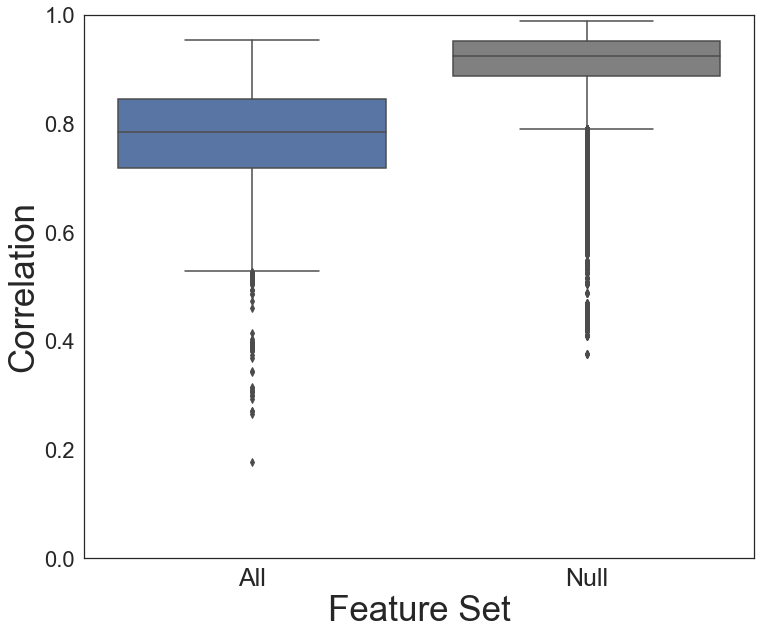

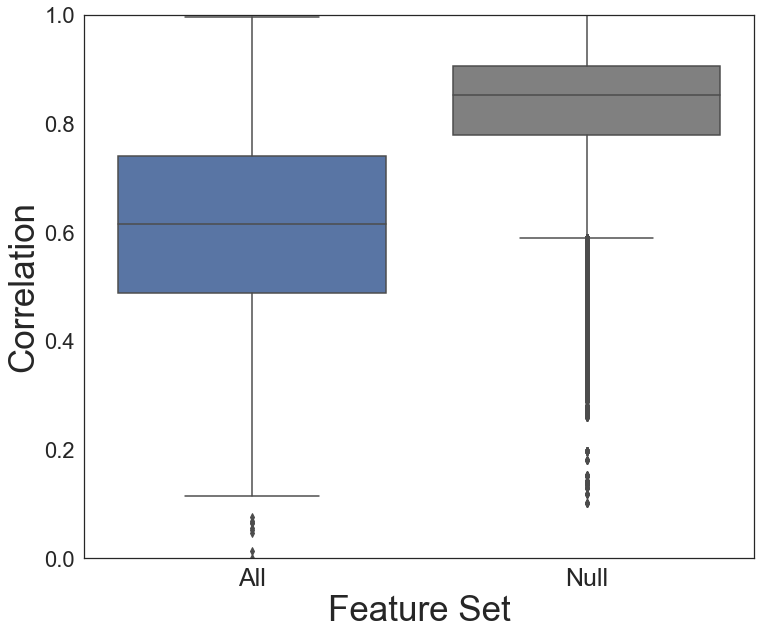

In [7]:
## Plot map-wise and region-wise r-squared

sns.set(style='white', font_scale=2)

df = df_corr
filetype = 'pdf'

fig_dir = 'figures/subject-specific-models'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

order = ['all', 'all-shuffle-tasks']
xticklabels = ['All', 'Null']
palette = ['b', 'grey']

labelsize = 35
ticksize = 25

metric = 'corrs_predsTrain'
plt.figure(figsize=(12,10))
ax = sns.boxplot(x='feature_set', y='corr', data=df[df['type']==metric], order=order, palette=palette)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Correlation', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
#plt.savefig(os.path.join(fig_dir, 'corr_with_trainingMean.%s' % filetype))
plt.ylim(0, 1);

metric = 'corr_preds'
plt.figure(figsize=(12,10))
ax = sns.boxplot(x='feature_set', y='corr', data=df[df['type']==metric], order=order, palette=palette)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Correlation', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
#plt.savefig(os.path.join(fig_dir, 'corr_betweenPreds.%s' % filetype))
plt.ylim(0, 1);